# ARMA model for Tesla stock price data

### importing all required libraries

In [30]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
from   IPython.display                 import  display
from   pylab                           import  rcParams 
from   datetime                        import  datetime, timedelta
from statsmodels.tsa.stattools         import  adfuller
from statsmodels.tsa.stattools         import  pacf
from statsmodels.tsa.stattools         import  acf
from statsmodels.graphics.tsaplots     import  plot_pacf
from statsmodels.graphics.tsaplots     import  plot_acf
from statsmodels.graphics.gofplots     import qqplot
from statsmodels.tsa.seasonal          import seasonal_decompose
#from statsmodels.tsa.arima_model       import  ARMA
from statsmodels.tsa.arima.model import ARIMA

#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

In [31]:
import os
os.getcwd()

'/Users/vb/Downloads/MTech/PES/Time_Series/Session_3/2. Faculty Notebook 12'

In [55]:
df= pd.read_csv(os.getcwd()+'/Tesla.csv')

In [56]:
#df= pd.read_csv(os.getcwd()+'/Tesla.csv', parse_dates=['Date'], index_col='Date')

In [57]:
df.head()

,Date,Close
0,05-01-2017 16:00,64.57
1,05-02-2017 16:00,63.78
2,05-03-2017 16:00,62.20
3,05-04-2017 16:00,59.09
4,05-05-2017 16:00,61.67


In [58]:
df.tail()

,Date,Close
437,1/25/2019 16:00:00,59.41
438,1/28/2019 16:00:00,59.28
439,1/29/2019 16:00:00,59.49
440,1/30/2019 16:00:00,61.75
441,1/31/2019 16:00:00,61.40


### As stock price data is available for buisness days only, time series might be discontinuos on daily basis. We should update the time series considering business days

In [59]:
from pandas.tseries.offsets import BDay

In [60]:
date = pd.date_range(start='05/01/2017', end='01/31/2019', freq=BDay())

In [61]:
date

DatetimeIndex(['2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12',
               ...
               '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', length=459, freq='B')

### adding business dates to time series as a new column

In [62]:
df

,Date,Close
0,05-01-2017 16:00,64.57
1,05-02-2017 16:00,63.78
2,05-03-2017 16:00,62.20
3,05-04-2017 16:00,59.09
4,05-05-2017 16:00,61.67
...,...,...
437,1/25/2019 16:00:00,59.41
438,1/28/2019 16:00:00,59.28
439,1/29/2019 16:00:00,59.49
440,1/30/2019 16:00:00,61.75


In [63]:
df['TimeStamp']=pd.DataFrame(date, columns=['Date'])

In [64]:
df.shape

(442, 3)

In [65]:
df.head()

,Date,Close,TimeStamp
0,05-01-2017 16:00,64.57,2017-05-01
1,05-02-2017 16:00,63.78,2017-05-02
2,05-03-2017 16:00,62.20,2017-05-03
3,05-04-2017 16:00,59.09,2017-05-04
4,05-05-2017 16:00,61.67,2017-05-05


In [66]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df_model = df.set_index('TimeStamp')
df_model.head()

,Date,Close
TimeStamp,,
2017-05-01,05-01-2017 16:00,64.57
2017-05-02,05-02-2017 16:00,63.78
2017-05-03,05-03-2017 16:00,62.20
2017-05-04,05-04-2017 16:00,59.09
2017-05-05,05-05-2017 16:00,61.67


### plotting time series

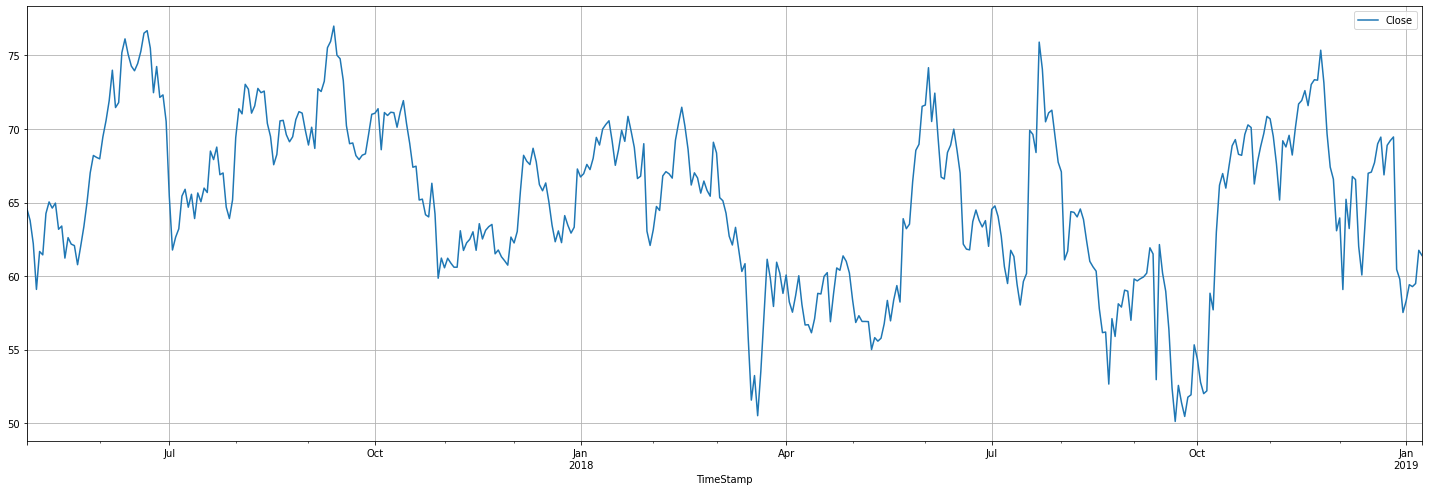

In [67]:
rcParams['figure.figsize'] = 25,8
df_model.plot(grid=True);

### dropping unwanted columns

In [68]:
df_model=df_model.drop('Date', axis=1)

In [69]:
df_model.head()

,Close
TimeStamp,
2017-05-01,64.57
2017-05-02,63.78
2017-05-03,62.20
2017-05-04,59.09
2017-05-05,61.67


### cheking for NA values

In [70]:
df_model.isna().value_counts()

Close
False    442
dtype: int64

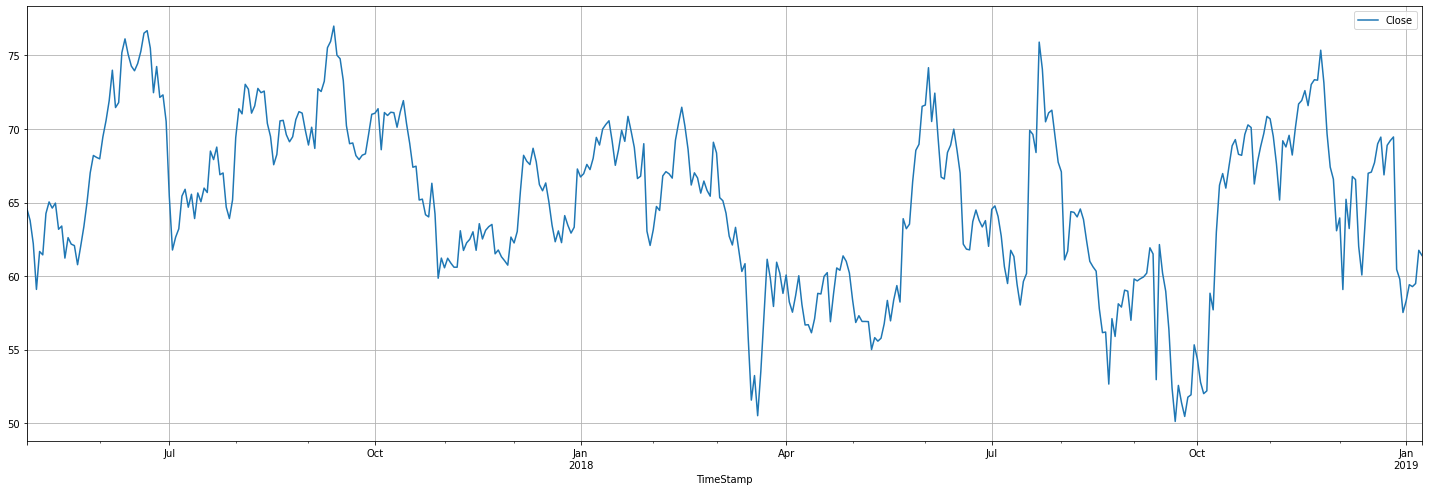

In [71]:
df_model.plot(grid=True);

### lets plot mean across the months to check whether the time series is stationary or not

<AxesSubplot:xlabel='TimeStamp'>

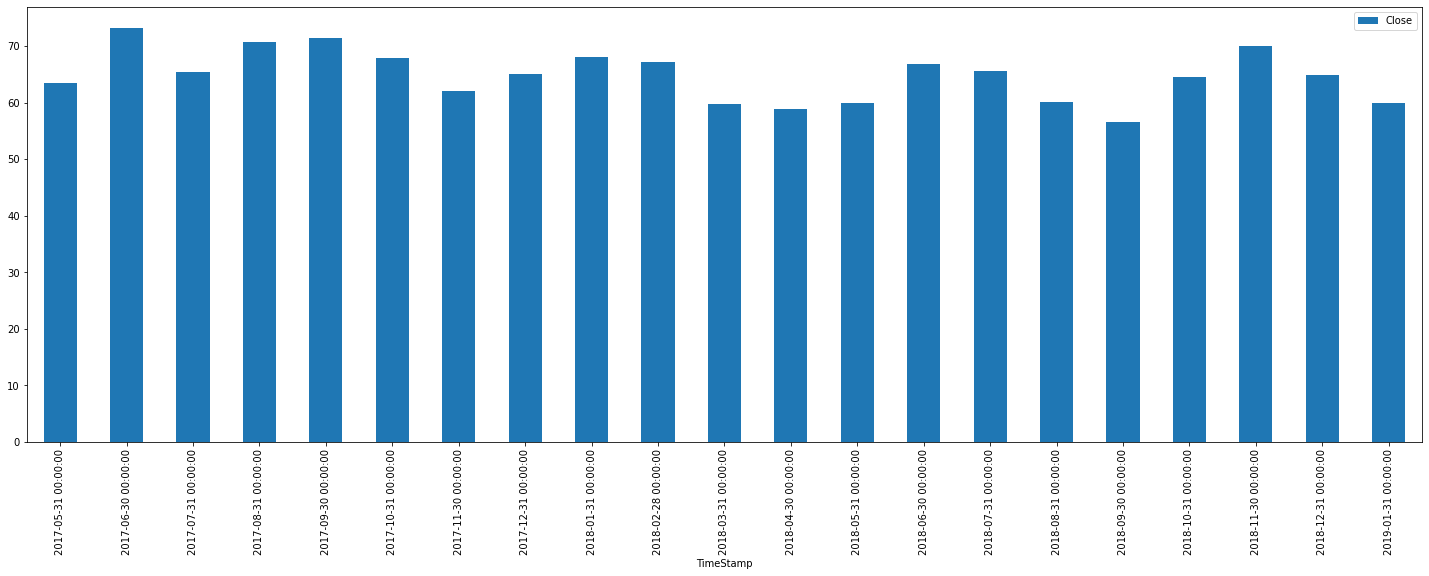

In [72]:
monthly_mean = df_model.resample('M').mean()
monthly_mean.plot.bar()

### It can be observed that there are no as such fluctuations in mean with respect to time

### Series seems to be stationary

### applying Adfuller test to confirm the same

In [73]:
observations= df_model.values
test_result = adfuller(observations)

In [74]:
test_result

(-3.8371932362652954,
 0.0025488986567834666,
 0,
 441,
 {'1%': -3.4452655826028318,
  '5%': -2.868116205869215,
  '10%': -2.570272878944473},
 1793.1284360926)

In [75]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -3.837193
p-value: 0.002549
Critical Values:
	1%: -3.44527
	5%: -2.86812
	10%: -2.57027


### test results confirms that the series is stationary

## Building ARMA model

### To find p and q values of AR() and MA() processes, lets plot ACF and PACF

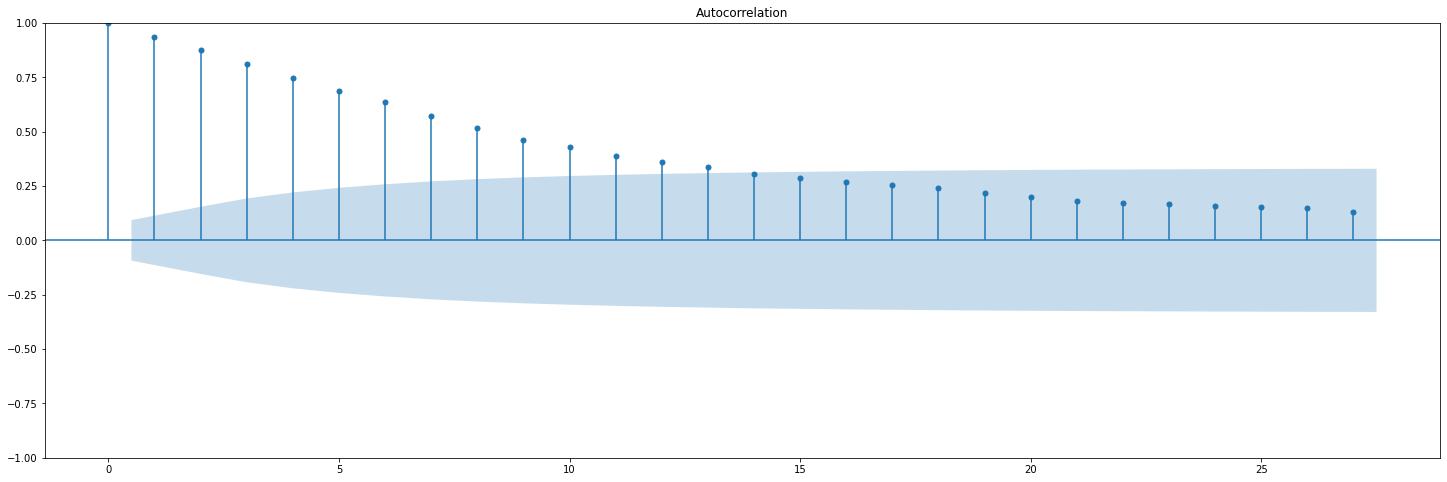

In [76]:
plot_acf(df_model);

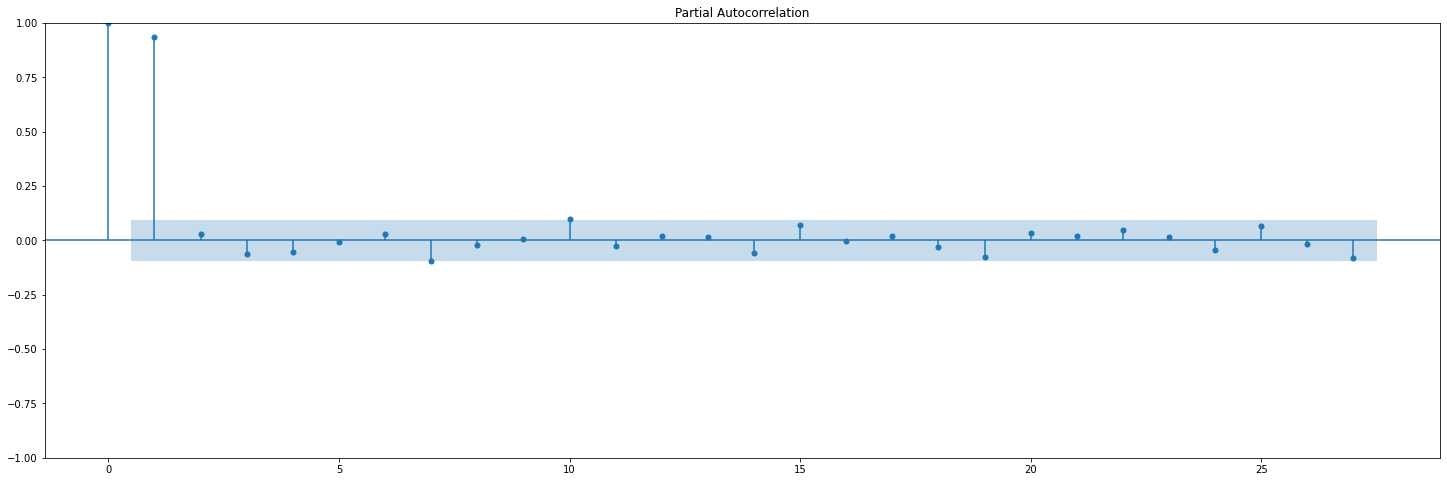

In [79]:
plot_pacf(df_model, method='ywm');

### ACF plot is clearly showing, time series observations are heavily impacted by past values. While PACF is showing limited number of spikes before cut-off

### Can select AR(1) and MA(0) process to build ARMA model

### splittng time series into training and testing sets

In [80]:
train_end=datetime(2018,10,30)
test_end=datetime(2019,1,31)

In [81]:
train             = df_model[:train_end] 
test              = df_model[train_end + timedelta(days=1):test_end]

In [82]:
train.shape

(392, 1)

### building ARMA model

In [97]:
#model=ARMA(train,(1,0))
model=ARIMA(train, order=(1, 0, 0))

/Users/vb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/vb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/vb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [98]:
model_fit=model.fit()

In [99]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  392
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -812.829
Date:                Tue, 09 Aug 2022   AIC                           1631.658
Time:                        16:31:28   BIC                           1643.572
Sample:                    05-01-2017   HQIC                          1636.380
                         - 10-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.9820      1.662     39.096      0.000      61.724      68.240
ar.L1          0.9387      0.016     58.576      0.000       0.907       0.970
sigma2         3.6832      0.160     23.064      0.0

### predicting forecasts using the model

In [100]:
pred_start=test.index[0]
pred_end=test.index[-1]

In [101]:
pred_end

Timestamp('2019-01-08 00:00:00')

In [102]:
forecast=model_fit.forecast(10)

In [103]:
forecast

2018-10-31    69.401455
2018-11-01    69.130595
2018-11-02    68.876335
2018-11-05    68.637658
2018-11-06    68.413609
2018-11-07    68.203291
2018-11-08    68.005863
2018-11-09    67.820535
2018-11-12    67.646566
2018-11-13    67.483259
Freq: B, Name: predicted_mean, dtype: float64

In [104]:
predictions=model_fit.predict(start=pred_start, end=pred_end)

### lets plot actual series and forecast

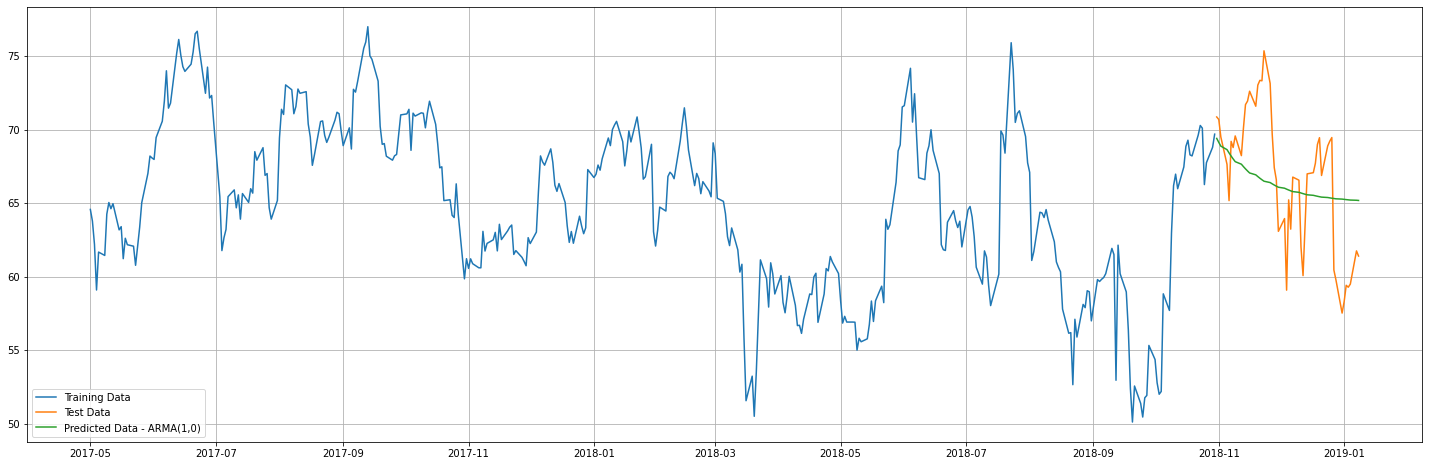

In [105]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,predictions,label='Predicted Data - ARMA(1,0)')
plt.legend(loc='best')
plt.grid();

### finding residuals

In [106]:
residuals = test.Close - predictions

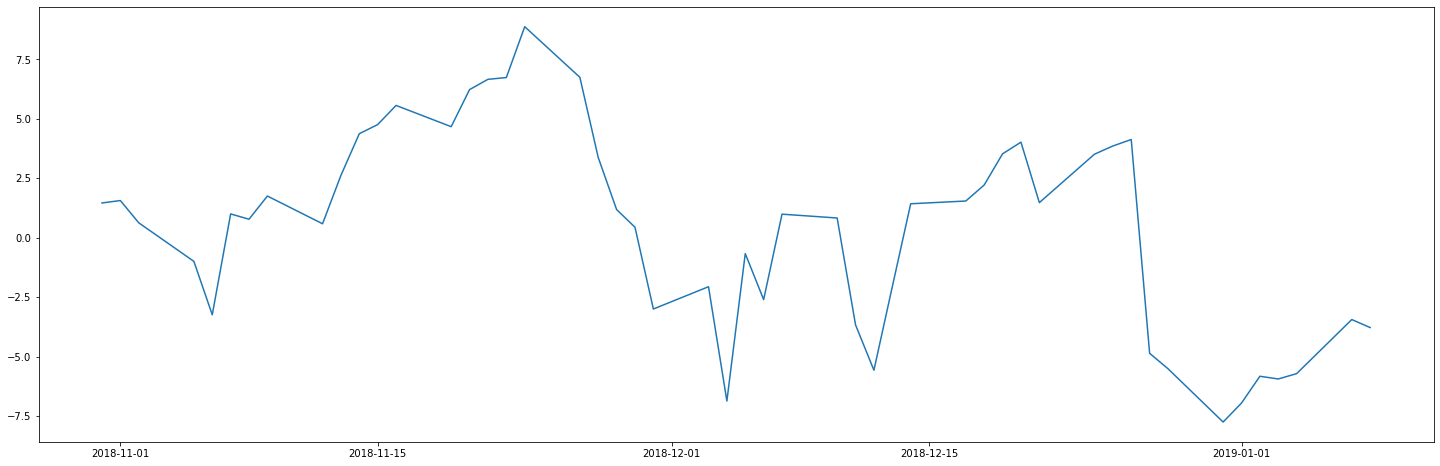

In [107]:
plt.plot(residuals)
plt.show()

### accuracy matrix

In [108]:
from sklearn.metrics import mean_squared_error

In [109]:
mean_squared_error(test.values,predictions.values,squared=False)

4.197927915882321

In [110]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [111]:
MAPE(test.values,predictions.values)

6.255632455434498

### residual q-q plot for to check model performance 

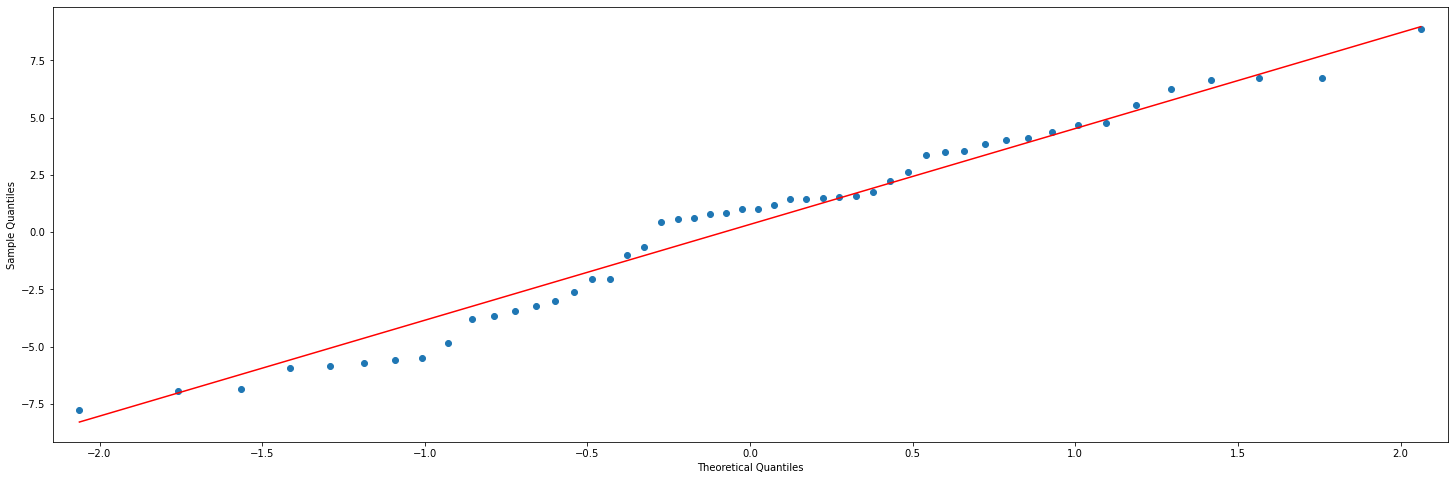

In [112]:
qqplot(residuals,line="s");

## forecast

In [113]:
#model=ARMA(df_model,(1,0))
model=ARIMA(df_model, order=(1,0,0))

/Users/vb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/vb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/vb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [118]:
model_fit = model.fit()

In [124]:
forecast = model_fit.forecast(15)
forecast

2019-01-09    61.636426
2019-01-10    61.856912
2019-01-11    62.062532
2019-01-14    62.254288
2019-01-15    62.433115
2019-01-16    62.599885
2019-01-17    62.755411
2019-01-18    62.900451
2019-01-21    63.035712
2019-01-22    63.161853
2019-01-23    63.279489
2019-01-24    63.389193
2019-01-25    63.491501
2019-01-28    63.586911
2019-01-29    63.675888
Freq: B, Name: predicted_mean, dtype: float64

In [125]:
import pandas as pd

forecasting = pd.DataFrame(forecast)

In [126]:
date = pd.date_range(start='01/09/2019', periods=15, freq=BDay())
forecasting['timestamp']=date
forecasting=forecasting.set_index('timestamp')
forecasting

,predicted_mean
timestamp,
2019-01-09,61.636426
2019-01-10,61.856912
2019-01-11,62.062532
2019-01-14,62.254288
2019-01-15,62.433115
2019-01-16,62.599885
2019-01-17,62.755411
2019-01-18,62.900451
2019-01-21,63.035712


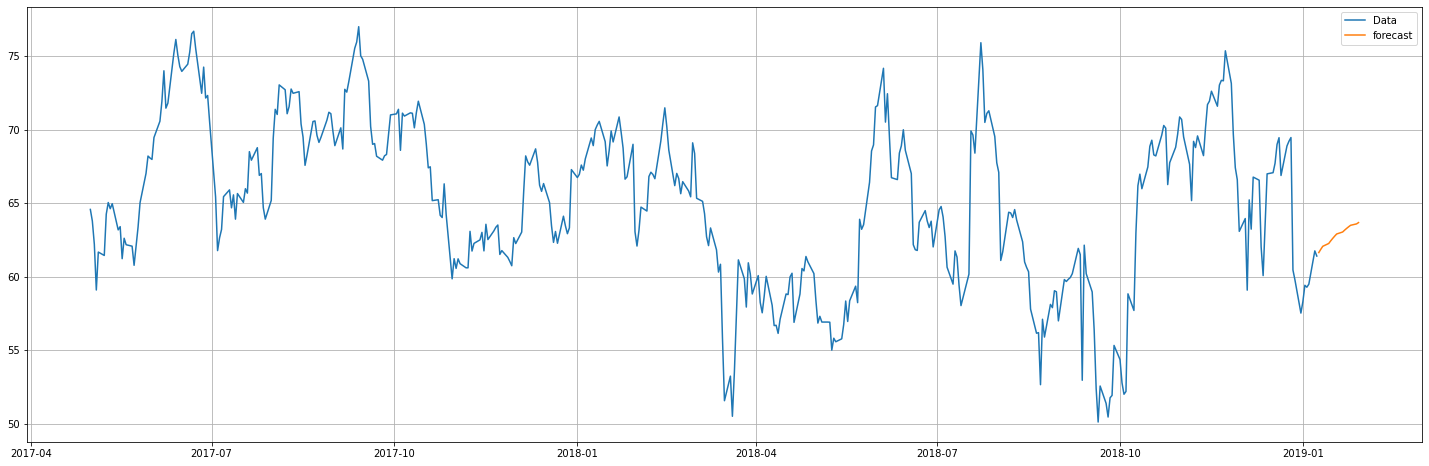

In [127]:
plt.plot(df_model,label='Data')
plt.plot(forecasting,label='forecast')
plt.legend(loc='best')
plt.grid();

# End